In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Neural Style Transfer Notes

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

## Load modules

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

%matplotlib inline

print(tf.__version__)

2.3.0


## Read the Images

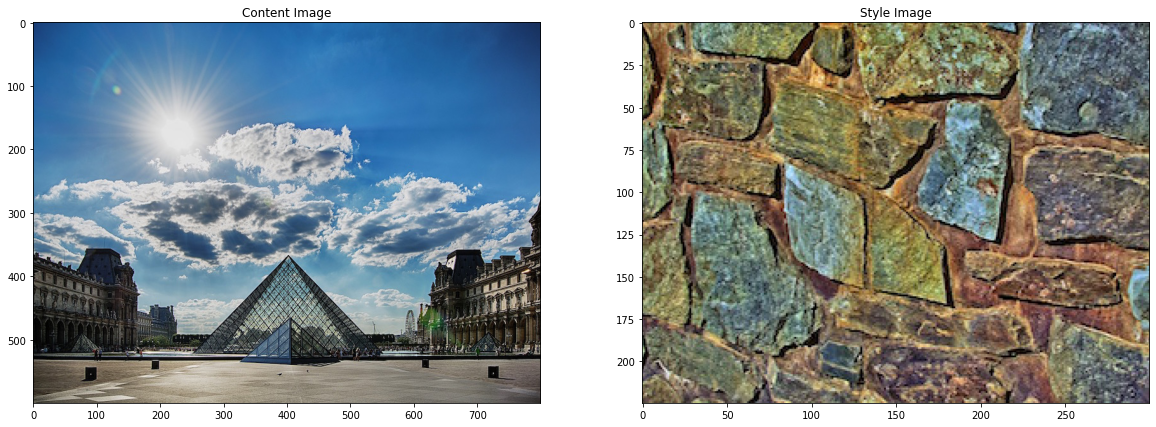

In [4]:
# Load the content and style images
content = plt.imread('/content/drive/My Drive/ColabNotebooks/NST/images/louvre.jpg')
style = plt.imread('/content/drive/My Drive/ColabNotebooks/NST/images/stone_style.jpg')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

## Helper function to load these images as numbers
### Takes in Image and Sends out tensor -> tensorshape [1, 400, 400, 3] where 1 represent 1 image and 400 X 400 & 3 Channels

In [5]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

## Use the helper function to load the pixel values of RGB channels

In [6]:
# Use load_image of content and style images
content = load_image('/content/drive/My Drive/ColabNotebooks/NST/images/louvre.jpg')
style = load_image('/content/drive/My Drive/ColabNotebooks/NST/images/stone_style.jpg')

# Verify the shapes
content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

## Load a pre-trained VGG19 model for extracting the features. As you will be using the model for extracting features, you will not need the classifier part of the model. it's picking a layer and extracting the learnt values w.r.t image at the layer

In [7]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


* The model is stored in a python dictionary.  
* The python dictionary contains key-value pairs for each layer.  
* The 'key' is the variable name and the 'value' is a tensor for that layer. 

#### Assign input image to the model's input layer
To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:  
```python
model["input"].assign(image)
```
This assigns the image as an input to the model. 

#### Activate a layer
After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:  
```python
sess.run(model["conv4_2"])
```

In [8]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### The authors of NST have specified the block names they had used for extracting the content and style features. The VGG19 model we just loaded has the same naming convention. 
#### So to take that advantage, you will first print the names of all the layers present in the network.



In [9]:
# Print the layer names for convenience
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### The style features are obtained from:

'conv1_1' #block 1 conv 1 <br>
'conv2_1' <br>
'conv3_1' <br>
'conv4_1' <br>
'conv5_1' <br>

### The content features are obtained from:
'conv4_2' <br>

#### Storing these blocks in variables

In [10]:
# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Create a custom VGG model which will be composed of the specified layers which helps us run forward passes on the images and extract the necessary features along the way.

In [11]:
def mini_model(layer_names, model):

  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)
  return model

### Define a gram matrix 

In [12]:
# Gram matrix
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

### Define a custom model using the mini_model() function. It will be used for returning the content and style features from the respective images.

In [13]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

### Using the custom layer defined above, to get style and content features of input images

In [14]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

### Optimization used in the paper is L-BFGS algorithm, but we can use Adam also.

In [15]:
opt = tf.optimizers.Adam(learning_rate=0.02)

### Define the overall content and style weights and also the weights for each of the style representations. Note that these are hyperparameters and we play for varied results

In [16]:
# Custom weights for style and content updates
style_weight=100
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

## Loss Function:

In [17]:
# The loss function to optimize
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Functions for:
    1. Calculate the gradients of the loss function you just defined.
    2. Use these gradients to update the target image.

In [18]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [19]:
#targetImage
target_image = tf.Variable(content)

## Train

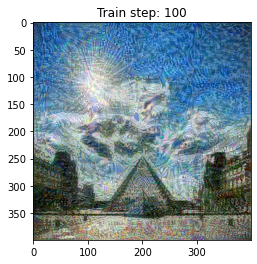

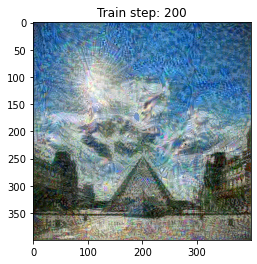

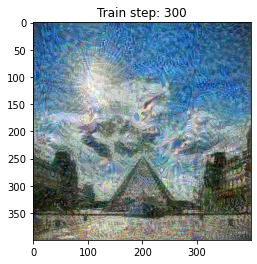

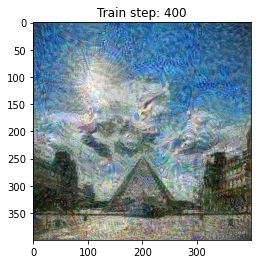

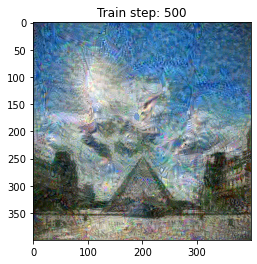

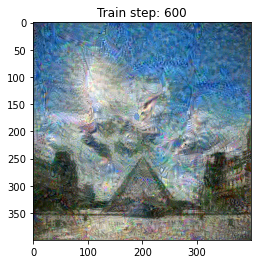

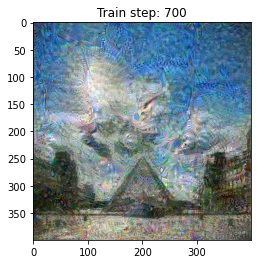

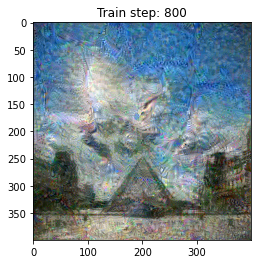

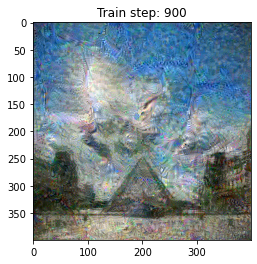

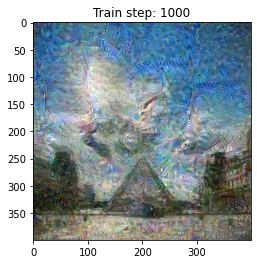

In [20]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()